# Comparação entre F-VI e A-VI
Este notebook compara a Inferência Variacional Fatorada (F-VI) e a Inferência Variacional Amortizada (A-VI) em dois modelos: um modelo hierárquico simples e um HMM simples.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Modelo Hierárquico Simples - F-VI

In [2]:
# Dados simulados
N = 100
tau = 1.0
sigma = 0.5
theta_true = torch.tensor(2.0)

z_true = torch.normal(theta_true, tau * torch.ones(N))
x_data = torch.normal(z_true, sigma)

In [3]:
mu = torch.randn(N, requires_grad=True)
log_std = torch.zeros(N, requires_grad=True)
optimizer = optim.Adam([mu, log_std], lr=0.05)

def elbo_fvi(x, mu, log_std):
    std = torch.exp(log_std)
    qz = torch.distributions.Normal(mu, std)
    z_samples = qz.rsample()
    log_px_z = torch.distributions.Normal(z_samples, sigma).log_prob(x).sum()
    log_pz = torch.distributions.Normal(theta_true, tau).log_prob(z_samples).sum()
    entropy = qz.entropy().sum()
    return log_px_z + log_pz + entropy

elbo_values_fvi = []
for step in range(300):
    optimizer.zero_grad()
    elbo = elbo_fvi(x_data, mu, log_std)
    loss = -elbo
    loss.backward()
    optimizer.step()
    elbo_values_fvi.append(elbo.item())
    if step % 50 == 0:
        print(f"Step {step}, ELBO: {elbo.item():.2f}")

Step 0, ELBO: -1666.61
Step 50, ELBO: -287.14
Step 100, ELBO: -178.70
Step 150, ELBO: -135.55
Step 200, ELBO: -146.76
Step 250, ELBO: -134.36


## Modelo Hierárquico Simples - A-VI

In [4]:
class InferenceNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        out = self.net(x.unsqueeze(1))
        mu, log_std = out[:, 0], out[:, 1]
        return mu, log_std

inference_net = InferenceNet()
optimizer_phi = optim.Adam(inference_net.parameters(), lr=0.01)

elbo_values_avi = []
for step in range(500):
    optimizer_phi.zero_grad()
    mu_pred, log_std_pred = inference_net(x_data)
    std_pred = torch.exp(log_std_pred)
    qz = torch.distributions.Normal(mu_pred, std_pred)
    z_samples = qz.rsample()
    log_px_z = torch.distributions.Normal(z_samples, sigma).log_prob(x_data).sum()
    log_pz = torch.distributions.Normal(theta_true, tau).log_prob(z_samples).sum()
    entropy = qz.entropy().sum()
    elbo = log_px_z + log_pz + entropy
    loss = -elbo
    loss.backward()
    optimizer_phi.step()
    elbo_values_avi.append(elbo.item())
    if step % 50 == 0:
        print(f"[A-VI] Step {step}, ELBO: {elbo.item():.2f}")

[A-VI] Step 0, ELBO: -1916.10
[A-VI] Step 50, ELBO: -155.74
[A-VI] Step 100, ELBO: -141.22
[A-VI] Step 150, ELBO: -141.61
[A-VI] Step 200, ELBO: -146.98
[A-VI] Step 250, ELBO: -131.42
[A-VI] Step 300, ELBO: -140.84
[A-VI] Step 350, ELBO: -142.58
[A-VI] Step 400, ELBO: -130.52
[A-VI] Step 450, ELBO: -137.90


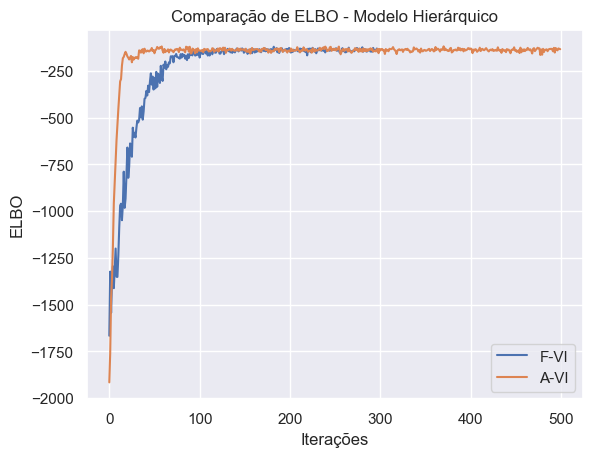

In [5]:
plt.plot(elbo_values_fvi, label='F-VI')
plt.plot(elbo_values_avi, label='A-VI')
plt.xlabel("Iterações")
plt.ylabel("ELBO")
plt.legend()
plt.title("Comparação de ELBO - Modelo Hierárquico")
plt.grid(True)
plt.show()

## Modelo HMM Simples

In [6]:
# Definindo HMM simples
T = 50
transition = torch.tensor([[0.9, 0.1], [0.1, 0.9]])
emission_means = torch.tensor([-2.0, 2.0])

z_states = [0]
x_obs = []

for t in range(T):
    if t > 0:
        z_t = torch.distributions.Categorical(transition[z_states[-1]]).sample().item()
        z_states.append(z_t)
    x_t = torch.normal(emission_means[z_states[-1]], 1.0)
    x_obs.append(x_t)

x_obs = torch.tensor(x_obs)
z_states = torch.tensor(z_states)

### F-VI no HMM

In [7]:
logits = torch.zeros(T, requires_grad=True)
optimizer = optim.Adam([logits], lr=0.05)

def elbo_hmm_fvi(x, logits):
    q_probs = torch.sigmoid(logits)
    z_samples = torch.bernoulli(q_probs)

    log_trans = 0
    for t in range(1, T):
        p = transition[int(z_samples[t - 1])]
        log_trans += torch.log(p[int(z_samples[t])])

    log_emit = torch.sum(torch.distributions.Normal(emission_means[z_samples.long()], 1.0).log_prob(x))
    entropy = -q_probs * torch.log(q_probs + 1e-8) - (1 - q_probs) * torch.log(1 - q_probs + 1e-8)
    return log_emit + log_trans + entropy.sum()

elbo_values_fvi_hmm = []
for step in range(300):
    optimizer.zero_grad()
    elbo = elbo_hmm_fvi(x_obs, logits)
    loss = -elbo
    loss.backward()
    optimizer.step()
    elbo_values_fvi_hmm.append(elbo.item())
    if step % 50 == 0:
        print(f"[F-VI HMM] Step {step}, ELBO: {elbo.item():.2f}")

[F-VI HMM] Step 0, ELBO: -246.01
[F-VI HMM] Step 50, ELBO: -298.78
[F-VI HMM] Step 100, ELBO: -314.04
[F-VI HMM] Step 150, ELBO: -281.73
[F-VI HMM] Step 200, ELBO: -253.77
[F-VI HMM] Step 250, ELBO: -265.54


### A-VI no HMM

In [8]:
class HMMInferenceNet(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(T, 64),
            nn.ReLU(),
            nn.Linear(64, T)
        )
    
    def forward(self, x):
        return self.net(x.unsqueeze(0)).squeeze(0)

hmm_net = HMMInferenceNet(T)
optimizer_hmm = optim.Adam(hmm_net.parameters(), lr=0.01)

elbo_values_avi_hmm = []
for step in range(300):
    optimizer_hmm.zero_grad()
    logits_pred = hmm_net(x_obs)
    q_probs = torch.sigmoid(logits_pred)
    z_samples = torch.bernoulli(q_probs)

    log_trans = 0
    for t in range(1, T):
        p = transition[int(z_samples[t - 1])]
        log_trans += torch.log(p[int(z_samples[t])])

    log_emit = torch.sum(torch.distributions.Normal(emission_means[z_samples.long()], 1.0).log_prob(x_obs))
    entropy = -q_probs * torch.log(q_probs + 1e-8) - (1 - q_probs) * torch.log(1 - q_probs + 1e-8)
    elbo = log_emit + log_trans + entropy.sum()
    loss = -elbo
    loss.backward()
    optimizer_hmm.step()
    elbo_values_avi_hmm.append(elbo.item())
    if step % 50 == 0:
        print(f"[A-VI HMM] Step {step}, ELBO: {elbo.item():.2f}")

[A-VI HMM] Step 0, ELBO: -306.04
[A-VI HMM] Step 50, ELBO: -298.39
[A-VI HMM] Step 100, ELBO: -256.38
[A-VI HMM] Step 150, ELBO: -270.52
[A-VI HMM] Step 200, ELBO: -303.34
[A-VI HMM] Step 250, ELBO: -339.39


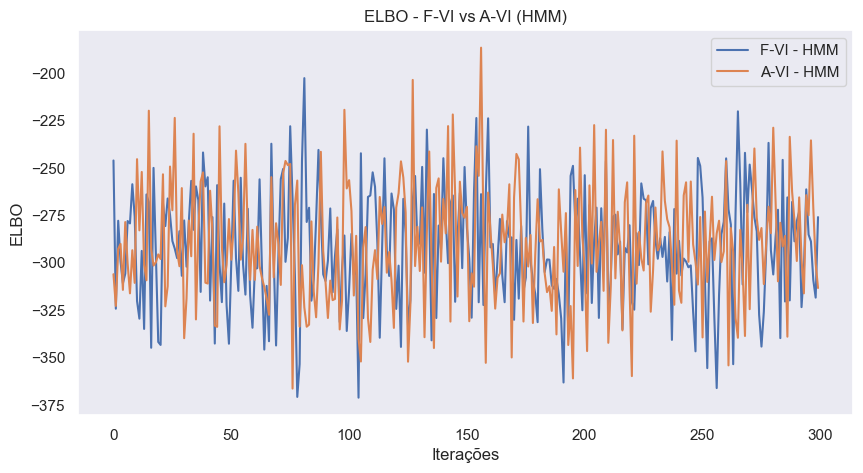

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(elbo_values_fvi_hmm, label='F-VI - HMM')
plt.plot(elbo_values_avi_hmm, label='A-VI - HMM')
plt.title("ELBO - F-VI vs A-VI (HMM)")
plt.xlabel("Iterações")
plt.ylabel("ELBO")
plt.legend()
plt.grid()
plt.show()

## O que é o Amortization Gap?
O **amortization gap** é a diferença de desempenho entre a Inferência Variacional Amortizada (A-VI) e a Inferência Variacional Fatorada (F-VI).

- Em **F-VI**, otimizamos uma distribuição variacional separadamente para cada dado, o que é mais flexível mas computacionalmente caro.
- Em **A-VI**, usamos uma rede neural para predizer os parâmetros da distribuição variacional, economizando tempo mas podendo introduzir um erro adicional — o amortization gap.

A seguir, visualizamos o impacto desse gap nos dois modelos.

## Visualização: Distribuições Variacionais (Modelo Hierárquico)

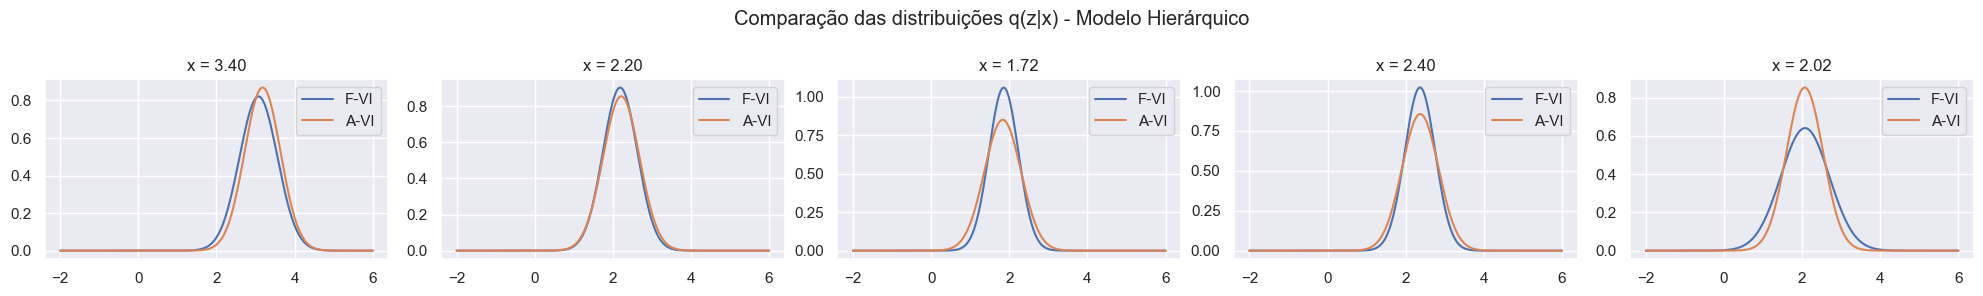

In [11]:
# Distribuições q(z|x) da F-VI e da A-VI para exemplos específicos
with torch.no_grad():
    mu_avi, log_std_avi = inference_net(x_data)
    std_avi = torch.exp(log_std_avi)

    # F-VI: distribuições variacionais treinadas separadamente
    mu_fvi = mu.detach()
    std_fvi = torch.exp(log_std.detach())

    idx = torch.randint(0, N, (5,))  # selecionar 5 exemplos aleatórios
    x_vals = torch.linspace(-2, 6, 200)

    fig, axs = plt.subplots(1, 5, figsize=(20, 3))
    for i, ax in enumerate(axs):
        i_idx = idx[i]

        # Criar uma Normal escalar (não vetorizada)
        q_fvi_i = torch.distributions.Normal(mu_fvi[i_idx], std_fvi[i_idx])
        q_avi_i = torch.distributions.Normal(mu_avi[i_idx], std_avi[i_idx])

        qi_fvi = torch.exp(q_fvi_i.log_prob(x_vals))
        qi_avi = torch.exp(q_avi_i.log_prob(x_vals))

        ax.plot(x_vals, qi_fvi, label='F-VI')
        ax.plot(x_vals, qi_avi, label='A-VI')
        ax.set_title(f"x = {x_data[i_idx].item():.2f}")
        ax.legend()

plt.suptitle("Comparação das distribuições q(z|x) - Modelo Hierárquico")
plt.tight_layout()
plt.show()


## Visualização: KL-divergência ao longo das épocas

C:\Users\dudda\AppData\Local\Temp\ipykernel_12840\247489889.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_fvi, kl_avi], labels=["F-VI", "A-VI"])


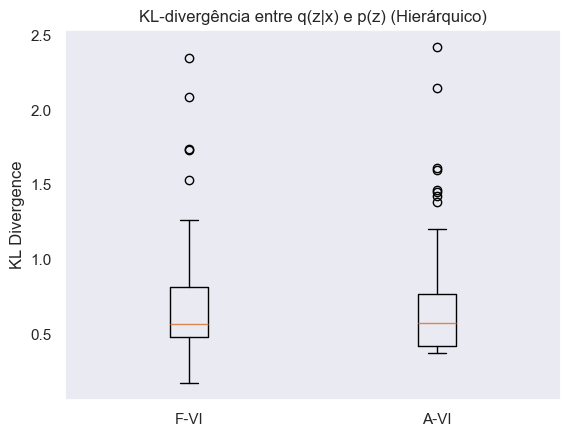

In [12]:
# Comparando a KL divergência entre q(z|x) e p(z) no modelo hierárquico
kl_fvi = []
kl_avi = []
prior = torch.distributions.Normal(theta_true, tau)
for i in range(N):
    qf = torch.distributions.Normal(mu[i].detach(), torch.exp(log_std[i].detach()))
    qa = torch.distributions.Normal(mu_avi[i].detach(), torch.exp(log_std_avi[i].detach()))
    kl_fvi.append(torch.distributions.kl.kl_divergence(qf, prior).item())
    kl_avi.append(torch.distributions.kl.kl_divergence(qa, prior).item())

plt.boxplot([kl_fvi, kl_avi], labels=["F-VI", "A-VI"])
plt.title("KL-divergência entre q(z|x) e p(z) (Hierárquico)")
plt.ylabel("KL Divergence")
plt.grid()
plt.show()

## Generalização da A-VI em Novos Dados (Hierárquico)

In [13]:
# Novo conjunto de dados (fora da amostra)
z_new = torch.normal(theta_true, tau * torch.ones(N))
x_test = torch.normal(z_new, sigma)

mu_test, log_std_test = inference_net(x_test)
std_test = torch.exp(log_std_test)
q_test = torch.distributions.Normal(mu_test, std_test)
z_test_sample = q_test.rsample()

log_px = torch.distributions.Normal(z_test_sample, sigma).log_prob(x_test).sum()
log_pz = torch.distributions.Normal(theta_true, tau).log_prob(z_test_sample).sum()
entropy = q_test.entropy().sum()
elbo_test = (log_px + log_pz + entropy).item()

print(f"ELBO médio fora da amostra (A-VI): {elbo_test:.2f}")

ELBO médio fora da amostra (A-VI): -165.68


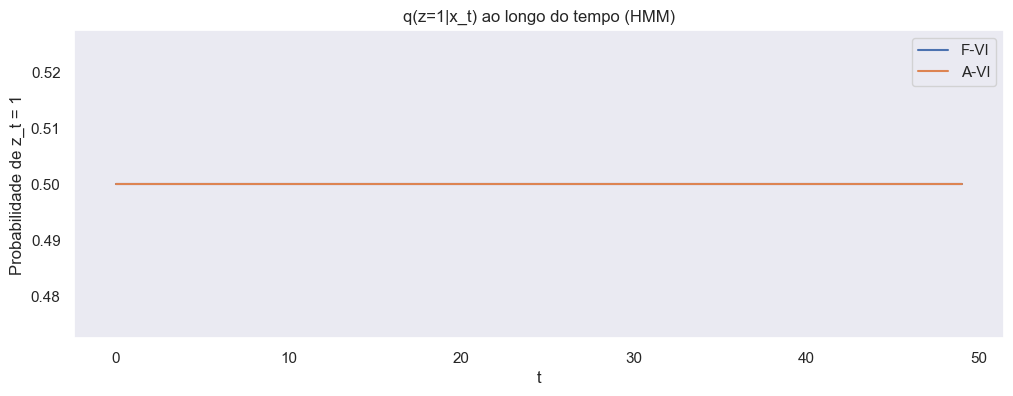

In [14]:
import matplotlib.pyplot as plt
import torch

# Assumimos que já existem:
# - logits: parâmetros da F-VI
# - hmm_net: rede da A-VI
# - x_obs: observações
# - z_states: estados verdadeiros

with torch.no_grad():
    q_fvi = torch.sigmoid(logits)                # Probabilidades inferidas por F-VI
    q_avi = torch.sigmoid(hmm_net(x_obs))        # Probabilidades inferidas por A-VI

# Gráfico das distribuições q(z=1 | x_t)
plt.figure(figsize=(12, 4))
plt.plot(q_fvi.numpy(), label="F-VI")
plt.plot(q_avi.numpy(), label="A-VI")
plt.title("q(z=1|x_t) ao longo do tempo (HMM)")
plt.xlabel("t")
plt.ylabel("Probabilidade de z_t = 1")
plt.legend()
plt.grid()
plt.show()


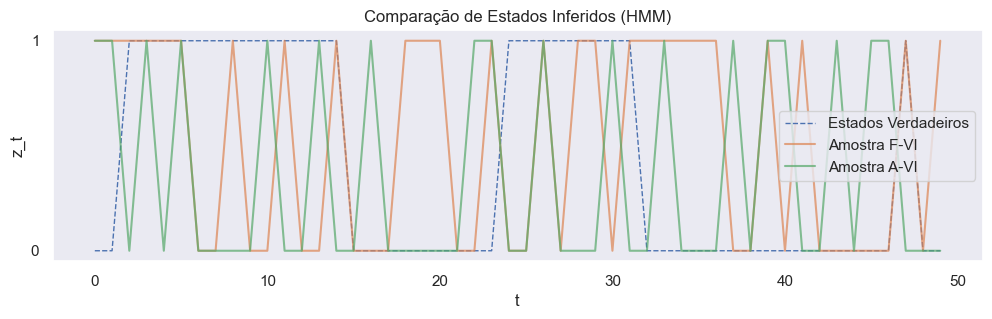

In [15]:
# Amostras de estados inferidos vs reais
z_fvi_sample = torch.bernoulli(q_fvi)
z_avi_sample = torch.bernoulli(q_avi)

plt.figure(figsize=(12, 3))
plt.plot(z_states.numpy(), label="Estados Verdadeiros", linestyle="--", linewidth=1)
plt.plot(z_fvi_sample.numpy(), label="Amostra F-VI", alpha=0.7)
plt.plot(z_avi_sample.numpy(), label="Amostra A-VI", alpha=0.7)
plt.title("Comparação de Estados Inferidos (HMM)")
plt.xlabel("t")
plt.ylabel("z_t")
plt.yticks([0, 1])
plt.legend()
plt.grid()
plt.show()


In [16]:
import time

# Tempo para F-VI no HMM
start_fvi = time.time()
for _ in range(50):
    optimizer.zero_grad()
    loss = -elbo_hmm_fvi(x_obs, logits)
    loss.backward()
    optimizer.step()
end_fvi = time.time()

# Tempo para A-VI no HMM
start_avi = time.time()
for _ in range(50):
    optimizer_hmm.zero_grad()
    logits_pred = hmm_net(x_obs)
    q_probs = torch.sigmoid(logits_pred)
    z_samples = torch.bernoulli(q_probs)

    # ELBO para A-VI
    log_trans = 0
    for t in range(1, T):
        p = transition[int(z_samples[t - 1])]
        log_trans += torch.log(p[int(z_samples[t])])
    log_emit = torch.sum(torch.distributions.Normal(emission_means[z_samples.long()], 1.0).log_prob(x_obs))
    entropy = -q_probs * torch.log(q_probs + 1e-8) - (1 - q_probs) * torch.log(1 - q_probs + 1e-8)
    elbo = log_emit + log_trans + entropy.sum()

    loss = -elbo
    loss.backward()
    optimizer_hmm.step()
end_avi = time.time()

print(f"Tempo total F-VI (50 iterações): {end_fvi - start_fvi:.3f} segundos")
print(f"Tempo total A-VI (50 iterações): {end_avi - start_avi:.3f} segundos")


Tempo total F-VI (50 iterações): 0.090 segundos
Tempo total A-VI (50 iterações): 0.110 segundos
